## Прогнозирование уровня средней заработной платы в России

###  Визуальный анализ ряда

In [10]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
wage = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wage.rename(columns={'WAG_C_M': 'wage'}, inplace=True)
wage.head()

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


<Figure size 1008x504 with 0 Axes>

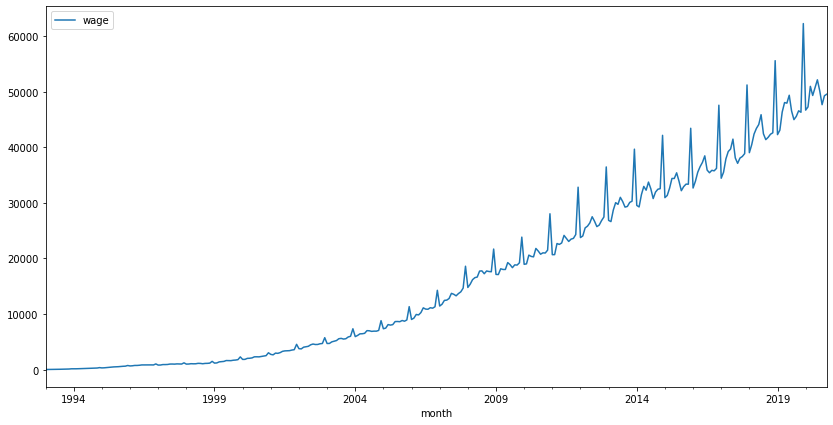

In [11]:
plt.figure(figsize(14,7))
wage.plot()
plt.show()

На графике зависимости ежемесячной зарплаты от времени видны:
- Ярко выраженный возрастающий тренд
- Сезонность
- Возрастающая со временем дисперсия

### Стабилизация дисперсии


Оптимальный параметр преобразования Бокса-Кокса: 0.294040
Критерий Дики-Фуллера: p=0.672732


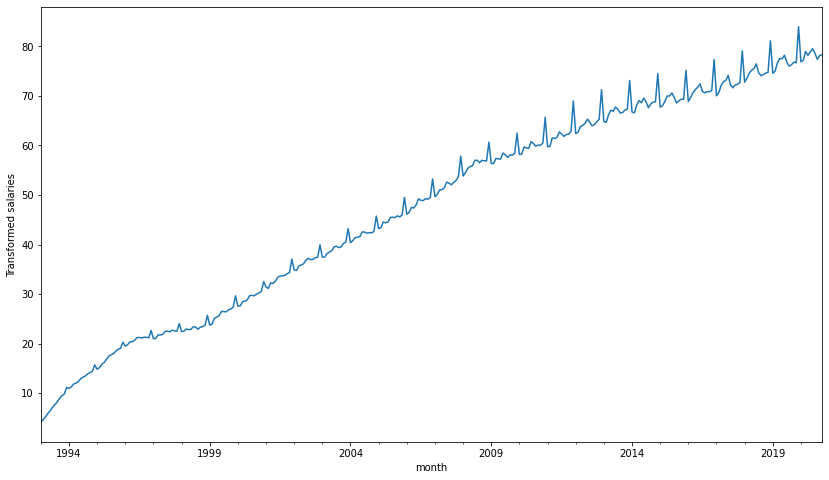

In [13]:
wage['wage_box'], ld = stats.boxcox(wage.wage)
plt.figure(figsize(14,8))
wage.wage_box.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % ld)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1])

### Стационарность
Проведем STL-декомпозицию и посмотрим на получившийся результат

Критерий Дики-Фуллера: p=0.672732


<Figure size 1080x720 with 0 Axes>

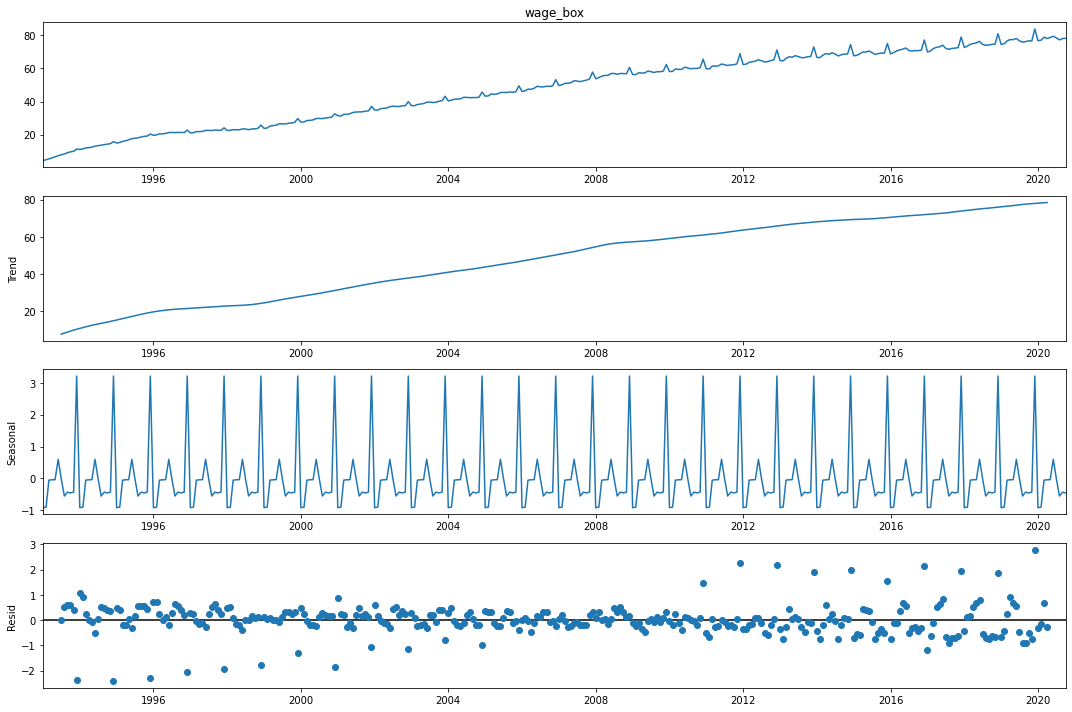

In [14]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1])

Значение критерия Дики-Фуллера: 0.673 - гипотеза о нестационарности  временного ряда не отвергается. В данных виден тренд.
Сделаем сезонное дифференцирование: на продифференцированном ряде осуществим STL-декомпозицию и проверим стационарность.


Критерий Дики-Фуллера: p=0.131512


<Figure size 1080x720 with 0 Axes>

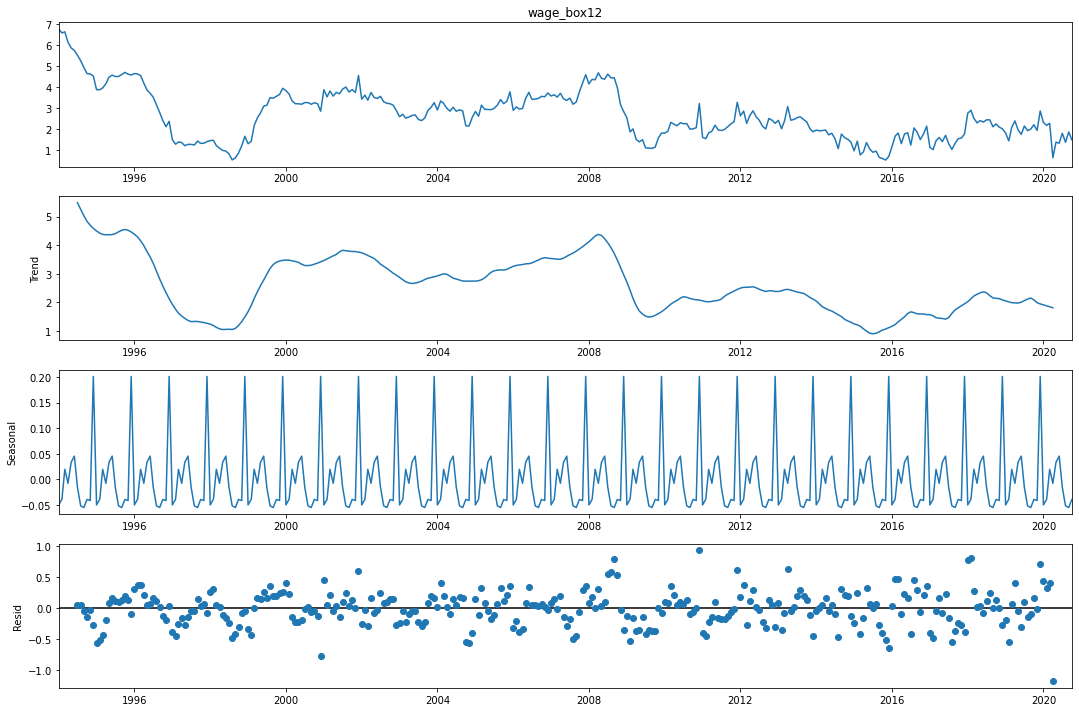

In [24]:
wage['wage_box12'] = wage.wage_box - wage.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box12[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box12[12:])[1])

Значение критерия Дики-Фуллера 0.13 не позволяет нам отвергнуть гипотезу о нестационарности нестационарность, но видно тренд еще  присутствует, поэтому проведем обычное дифференцирование:

In [26]:
wage['wage_box12_'] = wage.wage_box12 - wage.wage_box12.shift(1)

Критерий Дики-Фуллера: p=0.004377


<Figure size 1080x720 with 0 Axes>

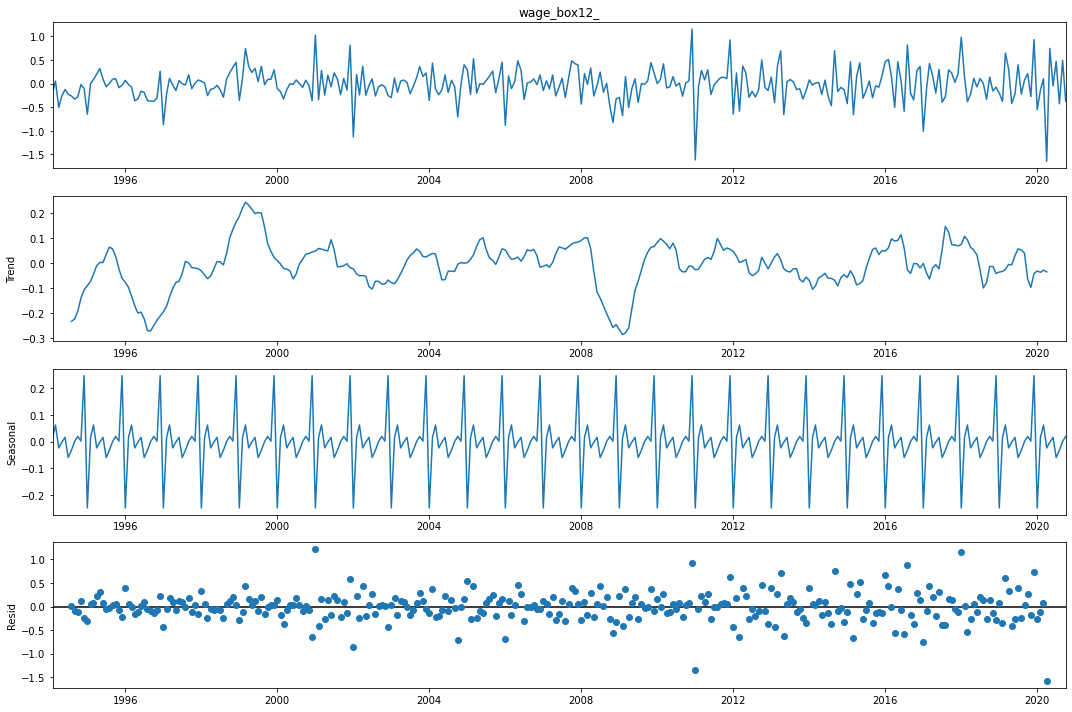

In [27]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box12_[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box12_[13:])[1])

Гипотеза нестационарности отвергается после применения сезонного и обычного дифференцирования. Тренд исчез, а остаток является шумом - получился стационарный ряд.

###  Подбор модели

Найдём параметры модели: p, P, q, Q:  
Коэффициенты q, Q будем подбирать по графику автокорреляции, p и P - по графику частичной корреляции.
Посмотрим на ACF и PACF полученного ряда:


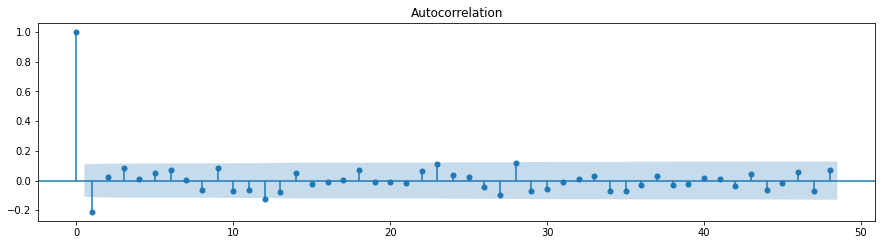

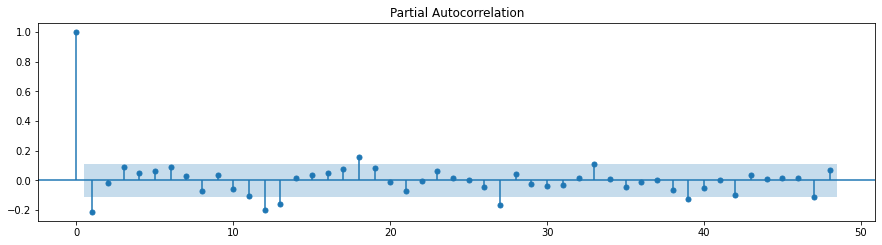

In [28]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_box12_[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_box12_[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()



Начальные приближения: Q = 1, q = 1, P = 1, p = 5.


In [50]:
ps = range(0, 6)
qs = range(0, 2)
Ps = range(0, 2)
Qs = range(0, 2)
D, d = 1,1

In [51]:
from itertools import product
parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

48

In [52]:
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters:
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    
    results.append([param, model.aic])

In [54]:
best = [best_model, best_param, best_aic]
best[1:]

[(3, 1, 1, 0), 210.63373205060117]

Лучшая модель:

In [55]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            wage_box   No. Observations:                  334
Model:             SARIMAX(3, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -99.317
Date:                             Thu, 21 Jan 2021   AIC                            210.634
Time:                                     23:08:33   BIC                            233.262
Sample:                                 01-01-1993   HQIC                           219.669
                                      - 10-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4285      0.222      1.931      0.053      -0.006       0.863
ar.L2          0.1708      

Её остатки:

Критерий Стьюдента: p=0.678593
Критерий Дики-Фуллера: p=0.000000


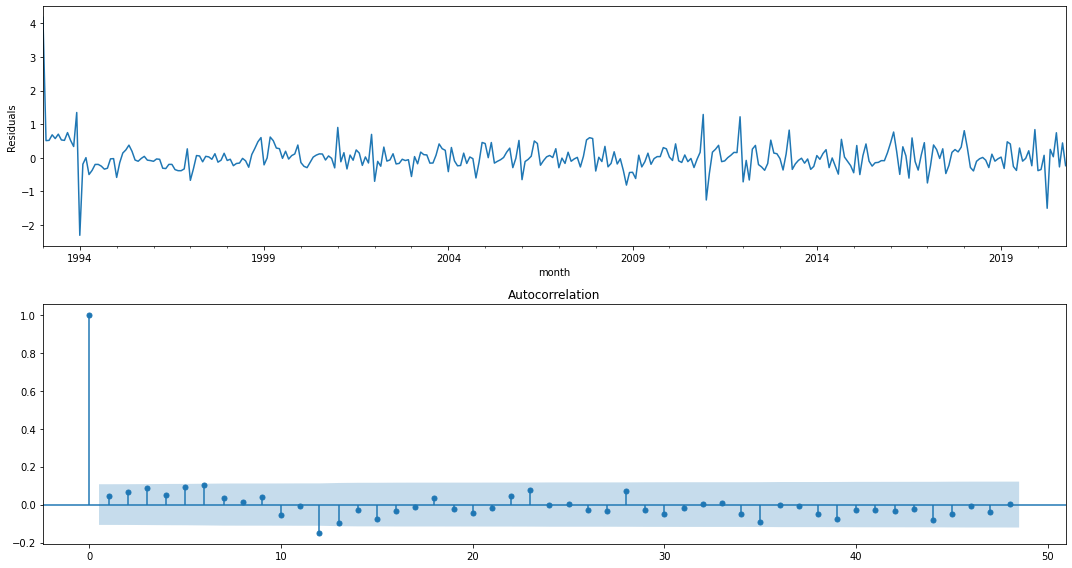

In [58]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])
plt.tight_layout()

Остатки несмещены (критерий Стьюдента), стационарны(критерий Дики-Фуллера), неавтокоррелированы (критерий Льюнга-Бокса и коррелограмма). Посмотрим, насколько хорошо модель описывает данные:

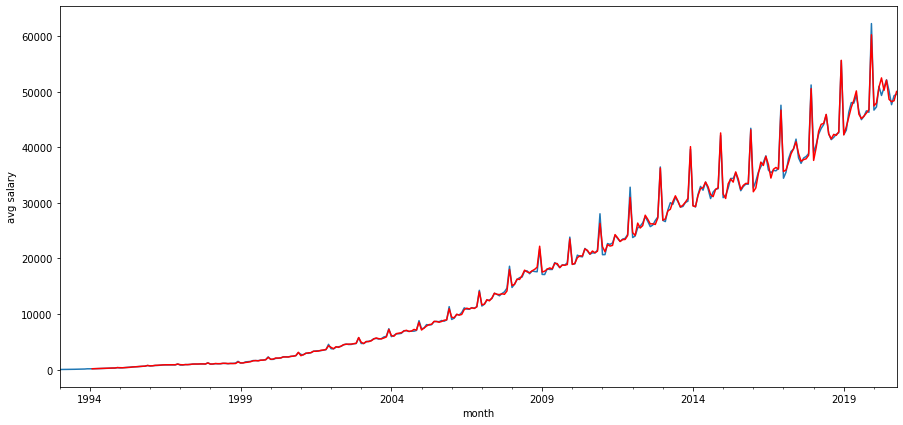

In [60]:
def invboxcox(y,ld):
    return np.exp(y) if ld == 0 else np.exp(np.log(ld*y + 1)/ld)

wage['model'] = invboxcox(best_model.fittedvalues, ld)
plt.figure(figsize(15,7))
wage.wage.plot()
wage.model[13:].plot(color='r')
plt.ylabel('avg salary')
pylab.show()

### Прогноз

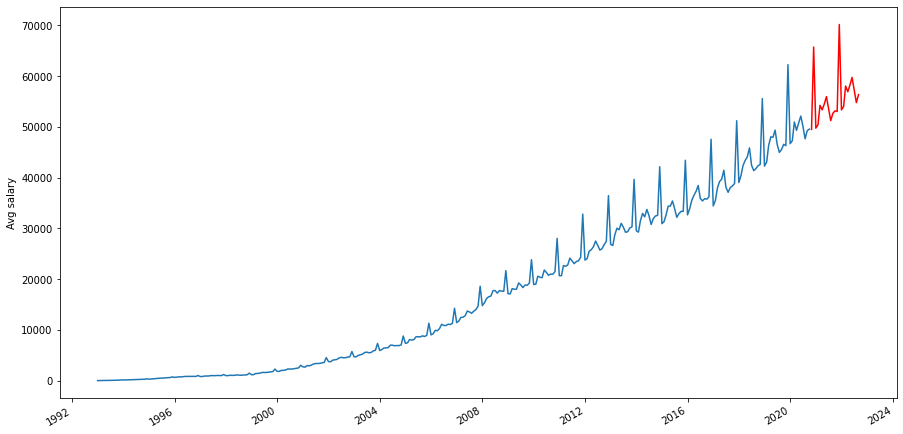

In [61]:
wage2 = wage[['wage']]
date_list = [datetime.datetime.strptime("2020-10-01", "%Y-%m-%d") + relativedelta(months = x) for x in range(0,24)]
future = pd.DataFrame(index = date_list, columns = wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start = wage.shape[0], end = wage.shape[0] + 24), ld)

plt.figure(figsize(15,8))
wage2.wage.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Avg salary')
pylab.show()